$
x_s^{0}=x_{init}\\
x_{s}^{t+1}=f(W_{s}x_{s}^{t}+W_{in}x_{in}^{t+1})\\
(f=tanh)
$

$
x_{in}
=
W_{spon}x_{spon}
+
W_{ex}x_{ex}
\\
x_{out}=ave(x_s^{t})
$

$
x_s\\
x_{in}\\
x_{out}
$

$
x_{spon}\\
x_{ex}
$

# Initialization of ESN

In [5]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

import scipy as sp
import networkx as nx
from numpy.random import RandomState
import copy

class Input_external:
    def __init__(self, dim_u, dim_x, input_scale, dtype=np.float32, rseed=0):
        '''
        dim_u: Dimension of the input
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        self.dtype = dtype
        #only first neuron receives noise
        #self.w_in = np.zeros((dim_x, dim_u))
        #self.w_in[:, 0]=np.random.uniform(-input_scale, input_scale, dim_u).T
        self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u))
        self.w_in = self.w_in.astype(self.dtype)

    
    def __call__(self, u):
        u = u.astype(self.dtype)
        return np.dot(self.w_in, u)

class Input_spon:
    def __init__(self, dim_u_spon, dim_x, input_scale=1.0, eps=0.20, r=4.0, dtype=np.float32, rseed=0, data_len=0):
        '''
        dim_u_spon: Dimension of the input from sponttaneous activities
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=0)
        self.input_scale=input_scale # variant for buf
        self.dtype = dtype
        self.data_len=data_len
        self.w_in = np.random.uniform(-self.input_scale, self.input_scale, (dim_x, dim_u_spon))
        self.w_in = self.w_in.astype(self.dtype)

        self.eps=eps # diffusive coupling strength
        self.r=r # control parameter r

        np.random.seed(seed=rseed)
        L = 2      # no. of lattice sites
        ic = np.random.uniform(0.1, 0.9, (L, dim_u_spon))  # random initial condition betn. (0,1)
        #print("spon_act_CML2d_ic = ", ic)
        self.CML2d=ic
        self.x_in_series=[] #1st_dim: time, 2nd_dim: input_dim(dim_u_spon)
        self.u_spon=[]
    
    def logistic(self, r, xforlog):
        return r*xforlog*(1-xforlog)
    
    def func1(self, a, x):
        return 1-(a*x)*x
    
    def next_x(self, f, x_2d):
        x_new = np.empty(x_2d.shape)
        x_new[0] = (1 - self.eps) * f(self.r,x_2d[0]) + self.eps * f(self.r,x_2d[1])
        x_new[1] = (1 - self.eps) * f(self.r,x_2d[1]) + self.eps * f(self.r,x_2d[0])
        return x_new

    def get_intermitt_series(self):
        for i in range(self.data_len):
            self.CML2d = self.next_x(self.logistic, self.CML2d).astype(self.dtype)# intermittent activities 2dCML or ESNnetwork
            self.x_in_spon=self.CML2d[0]-self.CML2d[1]
            #print(self.CML2d)
            self.x_in_series.append(self.x_in_spon)
        return np.array(self.x_in_series)

    def get_x_in_series(self):
        self.intermitt_series=self.get_intermitt_series()
        #print("self.intermitt_series.shape = ", self.intermitt_series.shape)
        intermitt_seriesT = self.intermitt_series.T
        np.random.seed(seed=0)
        #shuffle
        for arr in intermitt_seriesT:
            np.random.shuffle(arr)
        self.u_spon= intermitt_seriesT#shuffle as for time direction 
        return np.dot(self.w_in, self.u_spon).T

    def get_u_spon(self):
        return self.u_spon


class ESN1:
    def __init__(self, dim_x, activation_func=np.tanh, dtype=np.float32, rho=0.9,
        x_init=None, rseed=None, density=None):
        '''
        dim_x:           Dimension of the reservori states = Number of nodes in the Reservoir Network
        activation_func: Activation function to evolve the previous internal states
        rho:             Specified spectral radius for the internal weights matrix
        density:         Density of connection in the Reservoir layer
        '''
        self.dim_x = dim_x
        self.f = activation_func
        self.dtype = dtype
        self.rho = rho # speficy the spectral radius
        
        if x_init is None:
            self.x_init = np.zeros(dim_x, dtype=self.dtype)
        else:
            self.x_init = np.array(x_init, dtype=self.dtype)
        self.x = np.array(self.x_init)
        self.rseed = rseed
        self.rnd = RandomState(rseed)
        np.random.seed(seed=self.rseed)
        # initializing internal connections
        self.reset_weight(density)
    
    def reset_weight(self, density=None):
        np.random.seed(seed=self.rseed)
        self.density = 1.0 if density is None else density
        num_edges = int(self.dim_x * (self.dim_x - 1) * self.density / 2)
        
        G = nx.gnm_random_graph(self.dim_x, num_edges, self.rseed)
        self.w_net = np.array(nx.to_numpy_matrix(G))
        self.w_net = self.w_net.astype(self.dtype)
        self.w_net *= self.rnd.uniform(-1.0, 1.0, (self.dim_x, self.dim_x))
        
        # Compute spectral radius
        eigv_list = np.linalg.eig(self.w_net)[0]
        spectral_radius = np.max(np.abs(eigv_list))

        # Normalize the spectral radius
        self.w_net  *= (self.rho / spectral_radius)
        """
        self.w_net  =[[1.0, 0.1, -0.9, -0.3],
                      [0.5, 0.9, 0.2, 0.0],
                      [-0.7, 0.4, -0.3, 0.1],
                      [0.5, 0.1, 0.2, 1.0]]
        """

    def f_act(self, x=None):
        if x is None:
            x = self.x
            print("error")
        return self.f(x)
    
    def update(self, x_in):
        x_in = x_in.astype(self.dtype)
        
        self.x = self.f_act(np.dot(self.w_net, self.x) + x_in)
        #print("self.x[0] = ", buf_x[0], "  (np.dot(self.w_net, self.x) + x_in)[0] = ", (np.dot(self.w_net, self.x) + x_in)[0])
        #print("np.tanh( (np.dot(self.w_net, self.x) + x_in)[0]) =", np.tanh((np.dot(self.w_net, self.x) + x_in)[0]) )

    def reset_states(self, x_init=None):# not used 
        if x_init is None:
            x_init = self.x_init
        self.x = np.array(x_init)

    def get_states(self):
        return self.x

class Readout:
    def __init__(self, dim_x, dim_out, rseed=0):
        np.random.seed(seed=rseed)
        self.w_out = np.random.normal(size=(dim_out, dim_x))
    
    def __call__(self, x):
        return np.dot(self.w_out, x)
    
    def set_weight(self, w_out_opt):
        self.w_out = w_out_opt


class DESN_2kindsInput_1(ESN1):
    '''
    Discrete-time echo state network
    Inherit from ESN abstract class
    Add the Input and Readout layers
    
    #Variables including default params have order to define in any function 
    '''
    def __init__(self, dim_u_ex, dim_u_spon, dim_rv, input_scale_spon, activation_func, 
                 rseed=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, data_len=0, dim_out=0, x_init=None, **kwargs):
        #dim_rv: Dimension of the reservoir states
        super(DESN_2kindsInput_1, self).__init__(dim_rv, activation_func=activation_func, rseed=rseed,
                                                 x_init=x_init, **kwargs)#assign dim_rv to dim_x
        
        self.data_len=data_len
        #create instance
        ex_w_scale=1.0
        self.Input_external = Input_external(dim_u_ex, dim_rv, ex_w_scale, rseed=rseed)
        self.Input_spon = Input_spon(dim_u_spon, dim_rv, input_scale=input_scale_spon, eps=spon_eps, r=spon_r, 
                                     rseed=seed_spon, data_len=data_len)
        
        self.x_in_spon_series = self.Input_spon.get_x_in_series()
        self.iterate=0
        
        self.Readout = Readout(dim_rv, dim_out)
        self.states_series=[]
        self.dim_u_spon=dim_u_spon
        self.dim_u_ex=dim_u_ex

    def one_step(self, u_in):
        '''
        One-step evolution
        '''
        # Contribution from input
        x_in_external = self.Input_external(u_in)
        # Contribution from spontaneous activities
        x_in_spon = self.x_in_spon_series[self.iterate]
        self.iterate+=1
        # Update with previous states and activation function
        self.update( (x_in_external + x_in_spon)/(self.dim_u_spon + self.dim_u_ex) )

    def time_elapse(self, u_seq, washout_len = 200):
        '''
        Do not use the data in the washout phase for training
        '''
        for i in range(len(u_seq)):
            # Update the reservoir states
            self.one_step(u_seq[i])
            if i >= washout_len: 
              # True: use data
              self.states_series.append(self.get_states())
        return np.array(self.states_series)
    
    def predict(self, u_seq):
        '''
        Given the input sequence u_seq, predict the unknown output sequence
        Using the trained readout weights
        '''
        Y_pred_seq = []
        for i in range(len(u_seq)):
            self.one_step(u_seq[i])
            x_bias = np.concatenate([np.ones(1), self.x])
            y_pred = self.Readout(x_bias)
            Y_pred_seq.append(y_pred)
        return np.array(Y_pred_seq)

def DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=0.5, input_scale_spon=0.4, rseed=0, activation_func=np.tanh, 
                    washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, x_init=None, plot=True, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=dim_u_spon
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    
    # Define the model
    model = DESN_2kindsInput_1(seed_spon=seed_spon, dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale_spon=input_scale_spon, activation_func=activation_func, 
                             spon_eps=spon_eps, spon_r=spon_r, data_len=Time_leng, rho=rho, rseed=rseed, x_init=x_init)
    
    washout_len=washout_len
    # Time elapsed (時間が経過した-> 時間経過)
    states_series = model.time_elapse(u_ex, washout_len=washout_len) # 1st_dim: time, 2nd: nodes.
    x_in_spon=model.Input_spon.get_u_spon()
    # Predict
    """
    test_pred = model.predict(test_u)
    print("test_pred.shape", test_pred.shape)
    """
    # Evaluate
    
    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)
        #print(states_series[0])

     # Plot the target
    if (plot == True and dim_u_spon == 0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(2,1)

        time=np.arange(Time_leng)

        bar1=ax1[0].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[0].set_xlabel('time')
        ax1[0].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[1].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[1])
    
    # Plot the targett with spon_act
    if (plot == True and dim_u_spon>0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(3,1)

        time=np.arange(Time_leng)
        for arr in x_in_spon:
            ax1[0].plot(time, arr)

        bar1=ax1[1].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[2].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[2].set_xlabel('time')
        ax1[2].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[2])

        plt.show()
    return x_in_spon, states_series


## observation example

Debug
dim_u =  1
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 100)


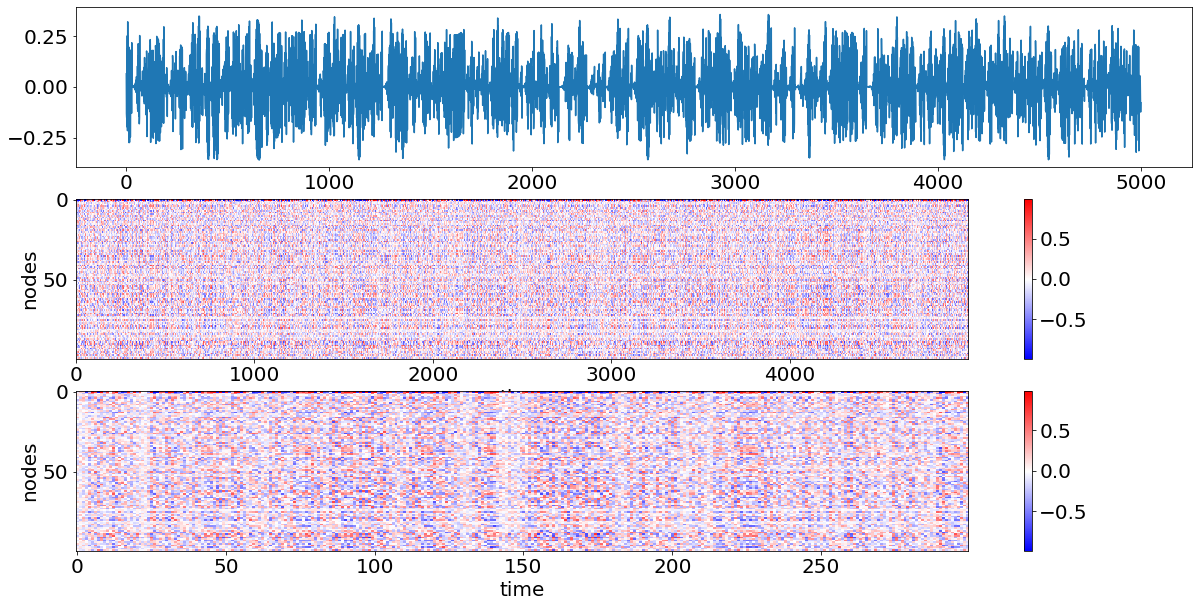

In [ ]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=100
dim_u=1
Time_leng=5000

x_init=np.random.uniform(-1.0, 1.0, dim_rv)
#print(x_init)

input_scale=1.0
rho=0.9
density=1.0

#change external input_scale 0.01~1.0
ex_input_scale=1.0
u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))

#print(u_ex)
rseed=1111
x_in_spon, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, 
                                         seed_spon=1, washout_len=0, spon_eps=0.20, spon_r=4.0, 
                                         x_init=x_init, plot=True, verbose=True)

# Lyapnov exponent about the state values in ESN

In [22]:
from numpy import linalg as LA

def DESN_Lyapnov(u_ex, dim_u_spon, dim_rv, density, input_scale_spon=0.4, rho=0.5, rseed=0, activation_func=np.tanh, 
                    washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, x_init=None, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=dim_u_spon
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    # Define the model
    model = DESN_2kindsInput_1(seed_spon=seed_spon, dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale_spon=input_scale_spon, activation_func=activation_func, 
                             spon_eps=spon_eps, spon_r=spon_r, data_len=Time_leng, rho=rho, rseed=rseed, x_init=x_init)
    
    x_in_spon, states_series=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, rho=0.5, input_scale_spon=0.4,
                                             rseed=0, activation_func=np.tanh, washout_len=0, seed_spon=0, 
                                             spon_eps=0.20, spon_r=4.0, x_init=None, plot=False, verbose=False)
    #states_series=states_series.T
    x_in_spon=x_in_spon.T
    #Lyapnov
    num_steps=10
    # the time length during which we take the average eigenvalue of Jacobian
    
    delta=0.001 #tiny change for derivative

    lyp_spec = []
    L = states_series.shape[0]

    #x_in=(x_in_external + x_in_spon)/(self.dim_u_spon + self.dim_u_ex)

    dim_u=dim_u_ex+dim_u_spon
    dx_list=np.identity(dim_rv)*delta
    for i in range(0, L, num_steps):
        ps_lyp = np.zeros(dim_rv)
        J=np.identity(dim_rv)
        for k in range(i, min(i+num_steps, L)):
            # Calculate the Jacobian matrix
            J_f = []
            x_in= (u_ex[k]+x_in_spon[k])/dim_u
            for j in range(dim_rv):
                #.f_act(np.dot(self.w_net, self.x) + x_in)
                J_f.append( 
                    (model.f_act( np.dot(model.w_net, states_series[k]+dx_list[j]) +x_in)
                    - model.f_act( np.dot(model.w_net, states_series[k]) +x_in) )/delta  
                    )

            J_f=np.array(J_f).T
            # Calculate the spectrum of the Jacobian matrix
            J=np.dot(J_f, J)

        A = np.dot(J, np.transpose(J))
        wa = LA.eigvalsh(A)
        ra = np.sqrt(np.abs(wa))
        #print(ra)
        idx = ra.argsort()[::-1]   
    
    ps_lyp = np.log(ra[idx]) /float(num_steps)#LLP

    lyp_spec.append(ps_lyp)
    #print(ps_lyp)
    lyp_spec = np.array(lyp_spec)
    #print(lyp_spec)#itinerary of LLP
    #print(lyp_spec.shape)
  
    # Take average spectrum overtime
    lyp_spec = np.mean(lyp_spec, axis=0)#GLP: average of LLP
    #print(lyp_spec.shape)


    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)
        #print(states_series[0])

    return lyp_spec


## lyapnov example

In [23]:
np.random.seed(1010)
dim_u_spon=1
dim_rv=10
dim_u=1
Time_leng=5000

x_init=np.random.uniform(-1.0, 1.0, dim_rv)
#print(x_init)

input_scale_spon=1.0
rho=0.9
density=1.0

#change external input_scale 0.01~1.0
ex_input_scale=1.0
u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))

#print(u_ex)
rseed=1111
lyp_spec=DESN_Lyapnov(u_ex, dim_u_spon, dim_rv, density, 
                      input_scale_spon=input_scale_spon, rho=rho, rseed=0, activation_func=np.tanh, 
                      washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, x_init=None, verbose=False)

# Bifurcation of Lypnov exponent

## rhos

In [ ]:
Time_leng=10**5+3000
ex_input_scale=1.0
#u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))
u_ex=ex_input_scale*np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
dim_u_spon=1
dim_rv=50
density=1.0

input_scale_spon=3.0

pLow = 0.01
pHigh = 3.00
nSteps = 100       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

rhos = np.arange(pLow, pHigh, pInc)

rseed=1111

lyp_spec_series=[]
for rho in rhos:
    lyp_spec=DESN_Lyapnov(u_ex, dim_u_spon, dim_rv, density, input_scale_spon=input_scale_spon, rho=rho, rseed=rseed,
                             washout_len=10**5, seed_spon=0, spon_eps=0.20, spon_r=4.0, verbose=False)
    lyp_spec_series.append(lyp_spec)
    

rhos.shape  (200,)
lyp_spec_series.shape  (200, 50)


<function matplotlib.pyplot.show(*args, **kw)>

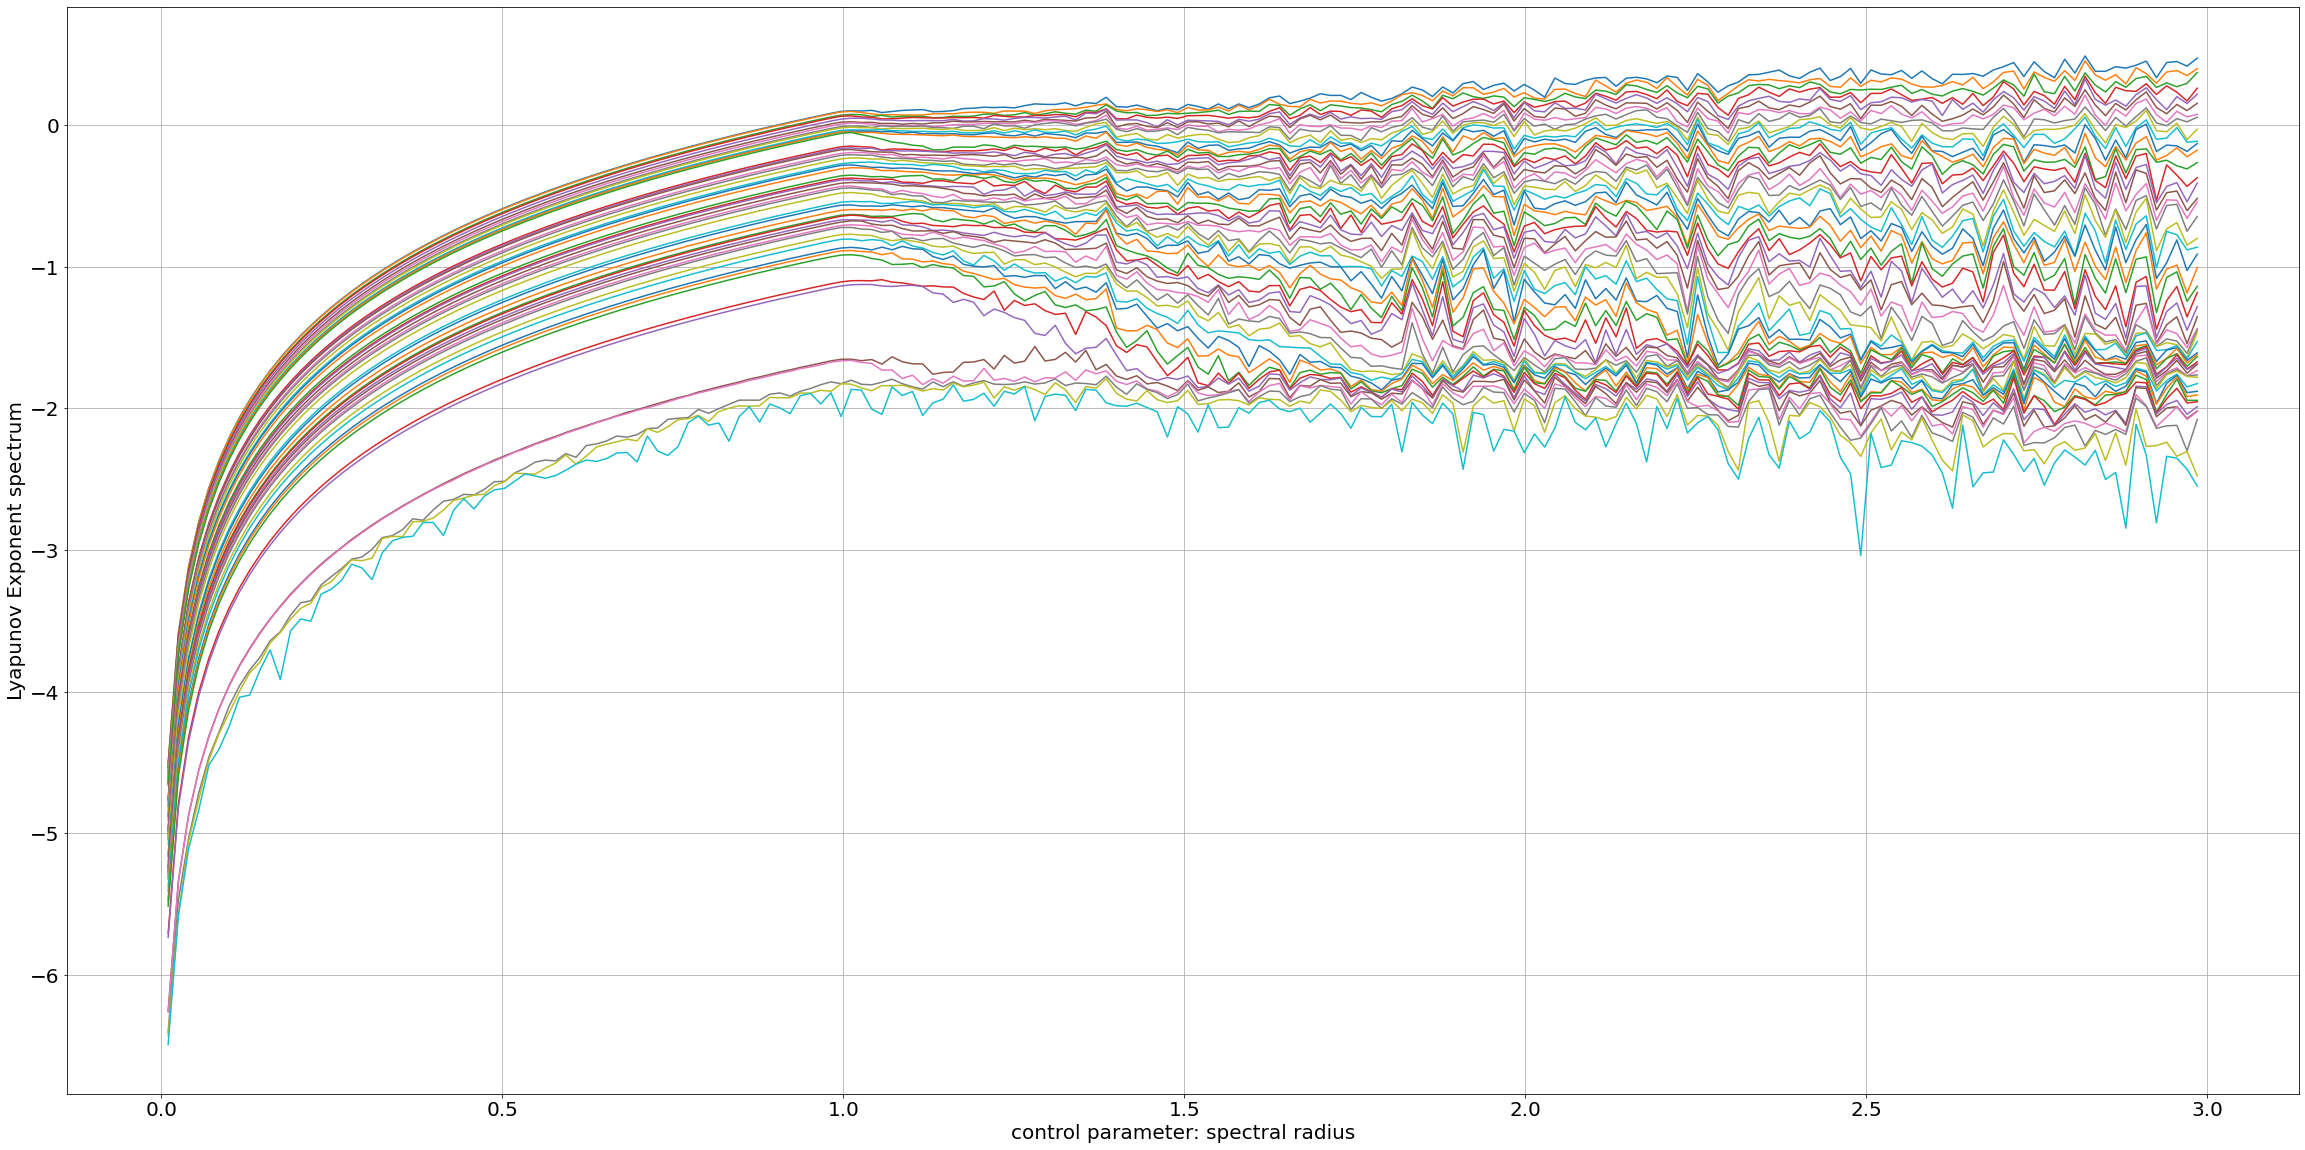

In [ ]:
plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel('control parameter: spectral radius')
ax1.set_ylabel('Lyapunov Exponent spectrum')

lyp_spec_series=np.array(lyp_spec_series)
print("rhos.shape ", rhos.shape)
print("lyp_spec_series.shape ", lyp_spec_series.shape)
series_len=lyp_spec_series.shape[1]
for i in range(series_len):
    ax1.plot(rhos, lyp_spec_series[:,i])

plt.grid()
plt.show


## input_scales

### rho=0.5

In [ ]:
Time_leng=5000
ex_input_scale=1.0
u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))

dim_u_spon=1
dim_rv=10
density=1.0

rho=0.5

pLow = 0.01
pHigh = 1.50
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

input_scales = np.arange(pLow, pHigh, pInc)

rseed=1111

lyp_spec_series=[]
for input_scale in input_scales:
    lyp_spec=DESN_Lyapnov(u_ex, dim_u_spon, dim_rv, density, input_scale=input_scale, rho=rho, rseed=rseed,
                             washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, verbose=True)
    lyp_spec_series.append(lyp_spec)
    

Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (500

rhos.shape  (200,)
lyp_spec_series.shape  (200, 10)


<function matplotlib.pyplot.show(*args, **kw)>

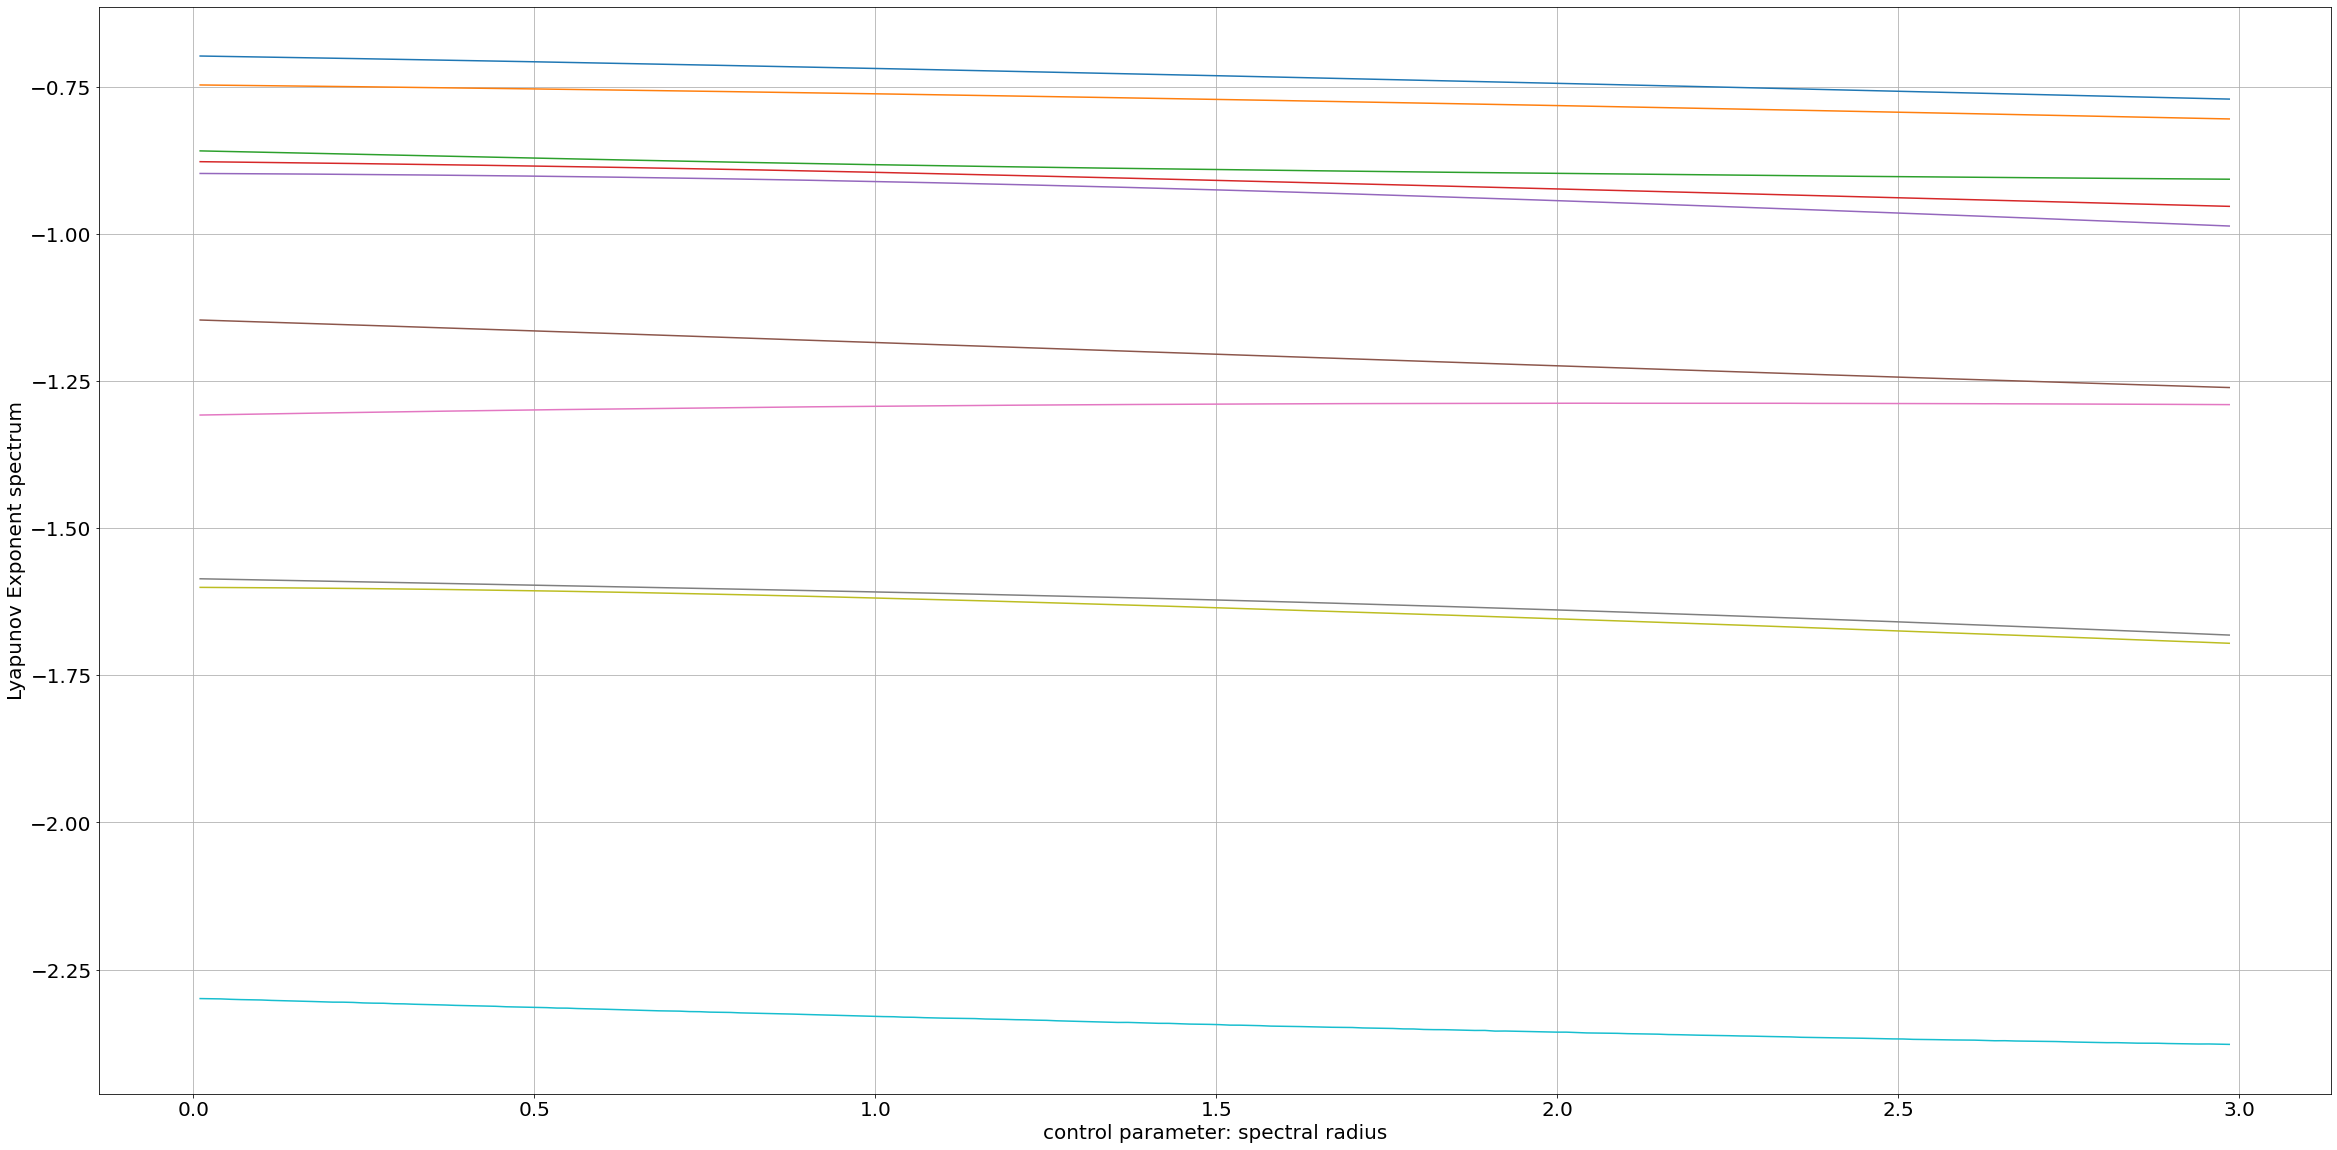

In [ ]:
plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel('control parameter: input_scale')
ax1.set_ylabel('Lyapunov Exponent spectrum')

lyp_spec_series=np.array(lyp_spec_series)
print("input_scales.shape ", input_scales.shape)
print("lyp_spec_series.shape ", lyp_spec_series.shape)
series_len=lyp_spec_series.shape[1]
for i in range(series_len):
    ax1.plot(input_scales, lyp_spec_series[:,i])

plt.grid()
plt.show


### rho=1.1

In [ ]:
Time_leng=5000
ex_input_scale=1.0
u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))

dim_u_spon=1
dim_rv=10
density=1.0

rho=1.1

pLow = 0.01
pHigh = 1.50
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

input_scales = np.arange(pLow, pHigh, pInc)

rseed=1111

lyp_spec_series=[]
for input_scale in input_scales:
    lyp_spec=DESN_Lyapnov(u_ex, dim_u_spon, dim_rv, density, input_scale=input_scale, rho=rho, rseed=rseed,
                             washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, verbose=True)
    lyp_spec_series.append(lyp_spec)
    

Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (500

input_scales.shape  (200,)
lyp_spec_series.shape  (200, 10)


<function matplotlib.pyplot.show(*args, **kw)>

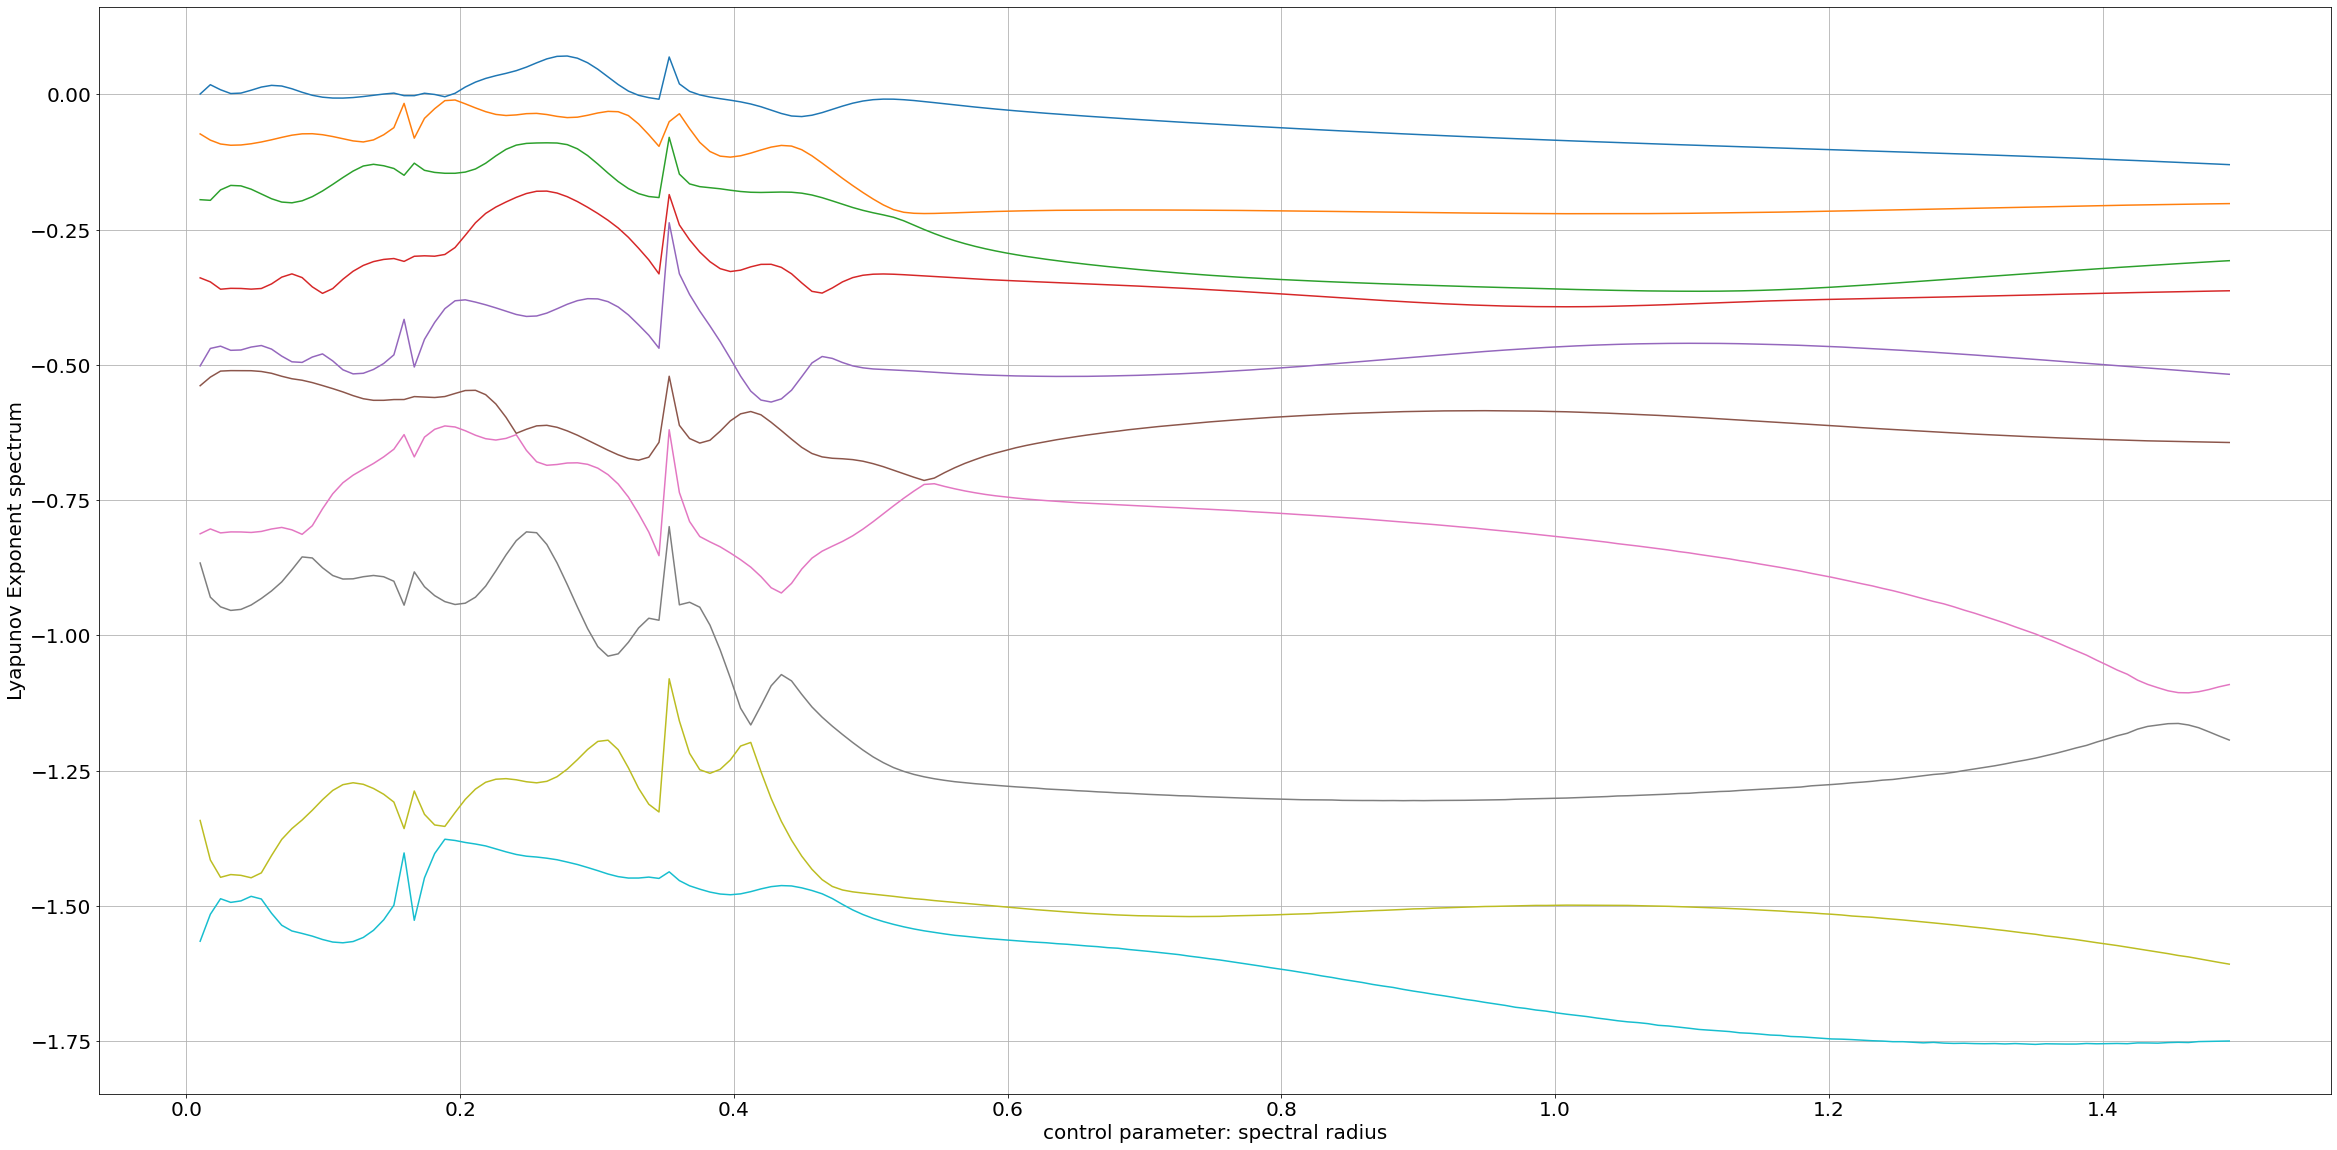

In [ ]:
plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel('control parameter: spectral radius')
ax1.set_ylabel('Lyapunov Exponent spectrum')

lyp_spec_series=np.array(lyp_spec_series)
print("input_scales.shape ", input_scales.shape)
print("lyp_spec_series.shape ", lyp_spec_series.shape)
series_len=lyp_spec_series.shape[1]
for i in range(series_len):
    ax1.plot(input_scales, lyp_spec_series[:,i])

plt.grid()
plt.show


## ex_input_scales


### rho=0.5

In [ ]:
Time_leng=5000

pLow = 0.01
pHigh = 1.50
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

input_scales = 0.4
rho=0.5

ex_input_scales = np.arange(pLow, pHigh, pInc)

dim_u_spon=1
dim_rv=10
density=1.0

rseed=1111

lyp_spec_series=[]
for ex_input_scale in ex_input_scales:
    u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))
    lyp_spec=DESN_Lyapnov(u_ex, dim_u_spon, dim_rv, density, input_scale=input_scale, rho=rho, rseed=rseed,
                             washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, verbose=True)
    lyp_spec_series.append(lyp_spec)
    

Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (500

rhos.shape  (200,)
lyp_spec_series.shape  (200, 10)


<function matplotlib.pyplot.show(*args, **kw)>

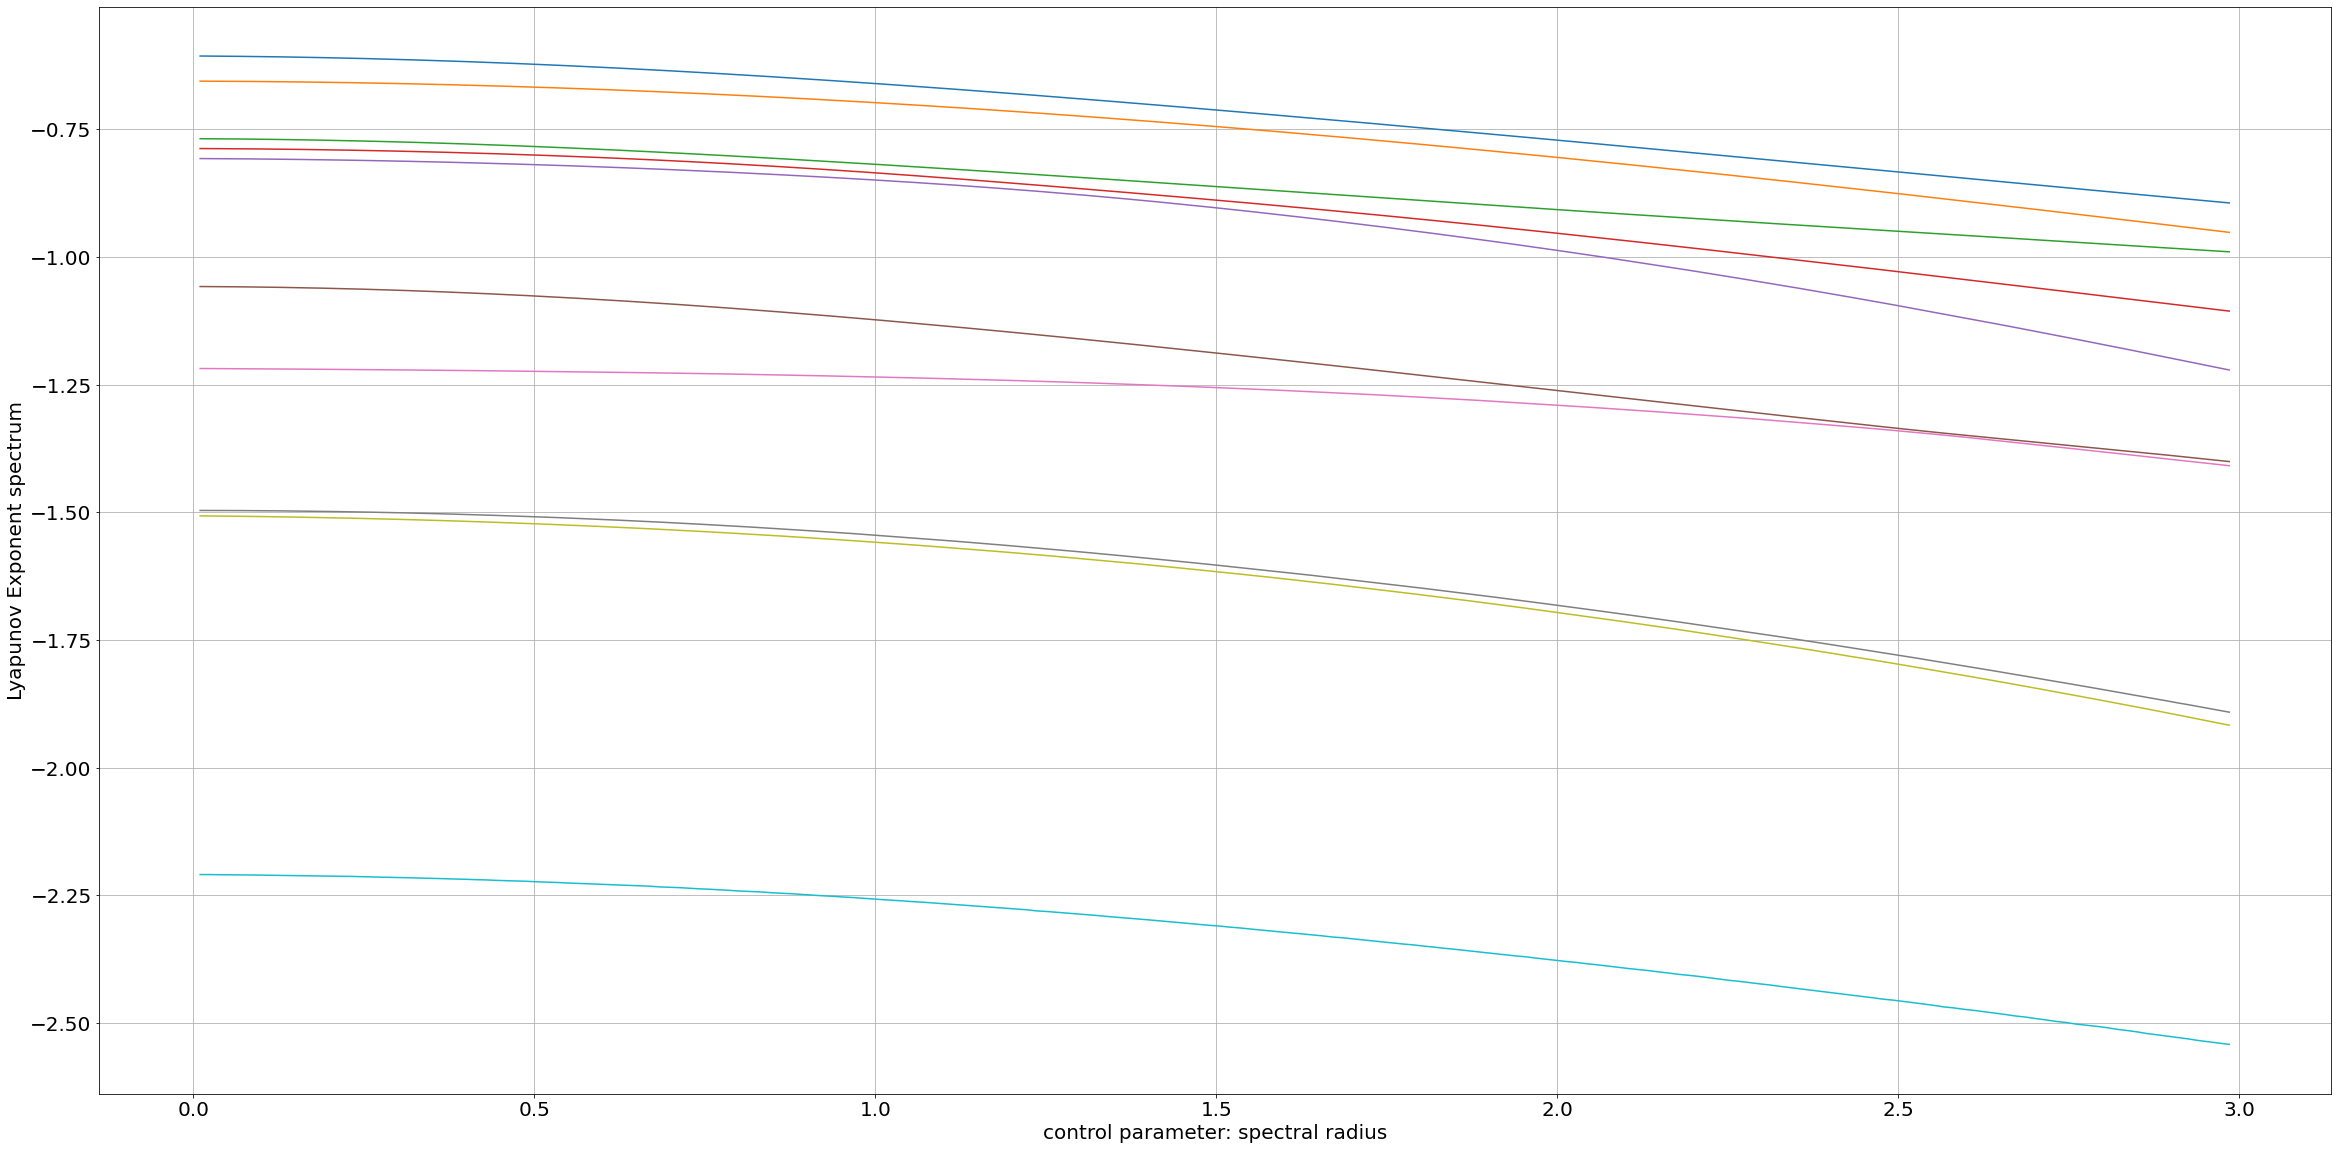

In [ ]:
plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel('control parameter: external input_scale')
ax1.set_ylabel('Lyapunov Exponent spectrum')

lyp_spec_series=np.array(lyp_spec_series)
print("ex_input_scales.shape ", ex_input_scales.shape)
print("lyp_spec_series.shape ", lyp_spec_series.shape)
series_len=lyp_spec_series.shape[1]
for i in range(series_len):
    ax1.plot(ex_input_scales, lyp_spec_series[:,i])

plt.grid()
plt.show


### rho=1.1

In [ ]:
Time_leng=5000

pLow = 0.01
pHigh = 1.50
nSteps = 200       # This sets how dense the bifurcation diagram will be
pInc = (pHigh - pLow) / nSteps

input_scales = 0.4
rho=1.1

ex_input_scales = np.arange(pLow, pHigh, pInc)

dim_u_spon=1
dim_rv=10
density=1.0

rseed=1111

lyp_spec_series=[]
for ex_input_scale in ex_input_scales:
    u_ex=np.random.uniform(-ex_input_scale, ex_input_scale, (Time_leng, dim_u))
    lyp_spec=DESN_Lyapnov(u_ex, dim_u_spon, dim_rv, density, input_scale=input_scale, rho=rho, rseed=rseed,
                             washout_len=0, seed_spon=0, spon_eps=0.20, spon_r=4.0, verbose=True)
    lyp_spec_series.append(lyp_spec)
    

Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (5000, 1)
states_series.shape =  (5000, 10)
Debug
dim_u =  2
x_in_spon.shape =  (500

ex_input_scales.shape  (200,)
lyp_spec_series.shape  (200, 10)


<function matplotlib.pyplot.show(*args, **kw)>

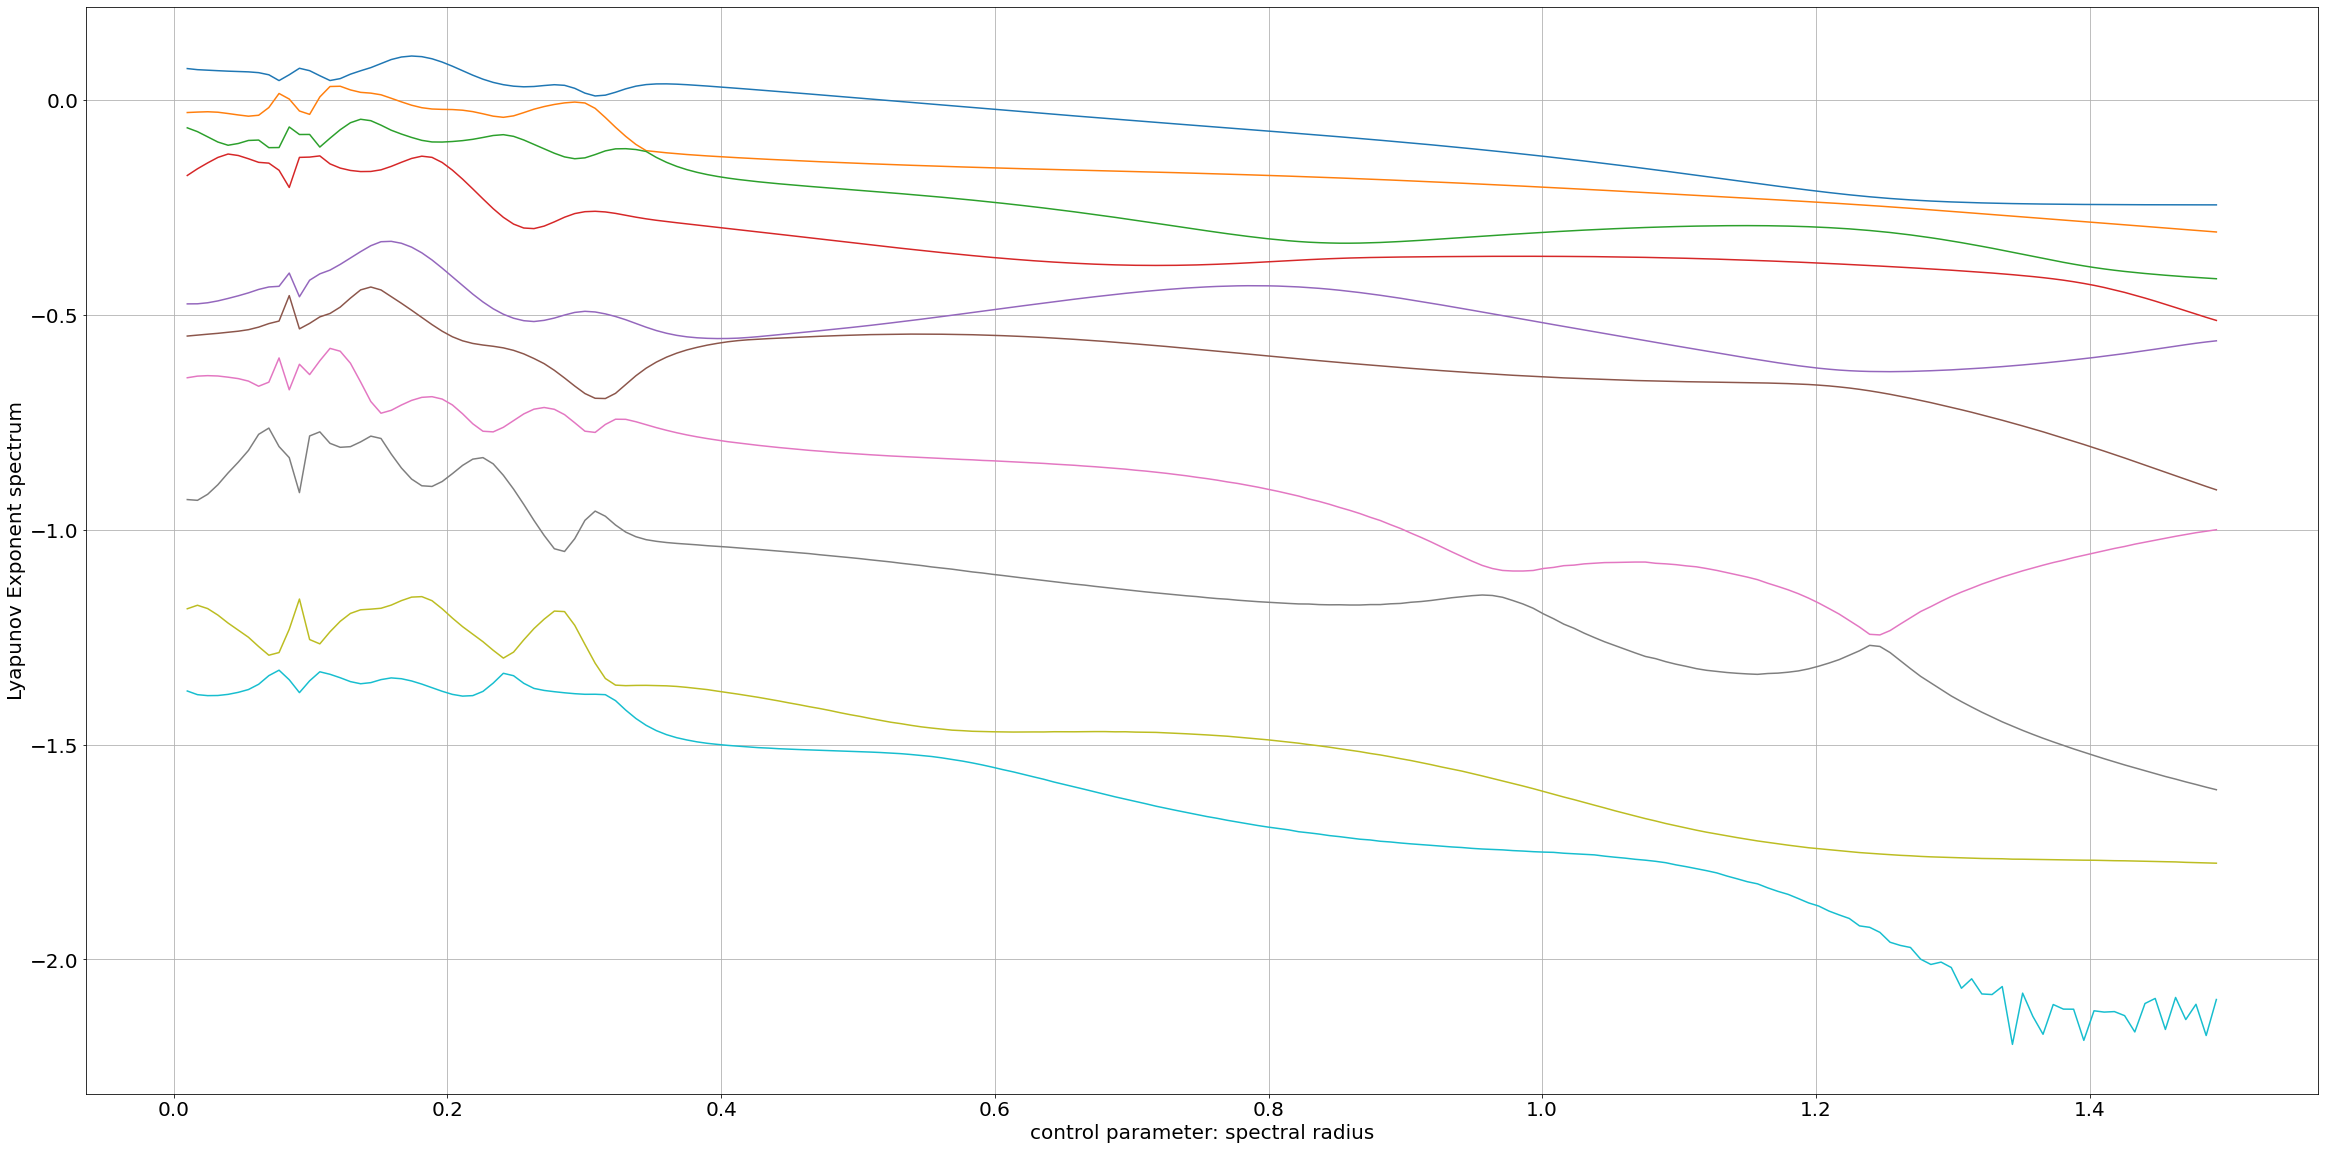

In [ ]:
plt.rcParams["figure.figsize"] = (40, 20)#(縦, 横)
fig=plt.figure()#(figsize=(100,100))
ax1=fig.subplots(1,1)
ax1.set_xlabel('control parameter: external input_scale')
ax1.set_ylabel('Lyapunov Exponent spectrum')

lyp_spec_series=np.array(lyp_spec_series)
print("ex_input_scales.shape ", ex_input_scales.shape)
print("lyp_spec_series.shape ", lyp_spec_series.shape)
series_len=lyp_spec_series.shape[1]
for i in range(series_len):
    ax1.plot(ex_input_scales, lyp_spec_series[:,i])

plt.grid()
plt.show
